<a href="https://colab.research.google.com/github/chorltonm/fa-cup-upsets/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Import general python libaries
import os
import json
import pandas as pd
import numpy as np
import importlib

# Google Cloud libraries
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata

# Scikit Learn libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from matplotlib import pyplot
import seaborn as sns




In [5]:
# Mount Google Drive
drive.mount('/content/drive')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')



Mounted at /content/drive


In [6]:
# Authentication credentials and keys

# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [7]:
# Feature Data

fa_cup_raw_features = """
    select * from preparation_layer.view_fa_cup_round_3_features
"""

fa_cup_raw_features_df = client.query(fa_cup_raw_features).to_dataframe()
display(fa_cup_raw_features_df)


,arena_stadium_capacity,home_team_round_3_position,home_team_massey,home_team_colley,home_team_keener,home_team_trueskill,home_team_borda_count,home_team_local_kemeny_optimisation,home_lineup_strength,home_team_league_form,...,match_weather_data_hours_dew,match_weather_data_hours_precip,match_weather_data_hours_snow,match_weather_data_hours_snowdepth,match_weather_data_hours_windspeed,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,target_variable
0,41837,1,1,1,12,1,1,1,NaN,0.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0
1,41837,1,1,1,12,1,1,1,0.82,0.00,...,34.70,0.000,0.0,0.00,4.80,1036.70,2.05,95.90,Overcast,0
2,41837,1,1,1,12,1,1,1,0.88,0.00,...,47.00,0.000,0.0,0.00,2.10,1031.70,4.20,87.00,Partially cloudy,0
3,74879,1,1,1,12,1,1,1,0.82,0.00,...,71.20,0.000,NaN,0.00,7.65,1015.50,5.15,67.10,Partially cloudy,0
4,74879,2,3,7,4,6,5,5,NaN,0.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,<NA>,64,58,64,53,63,64,64,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0
301,<NA>,64,58,64,53,63,64,64,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0
302,9527,64,58,64,53,63,64,64,0.90,0.22,...,37.15,0.000,0.0,0.00,14.45,1012.75,9.00,94.25,Overcast Partially cloudy,1
303,6064,64,58,64,53,63,64,64,0.15,NaN,...,41.45,0.000,0.0,0.00,6.35,1036.35,15.15,98.65,Overcast,0


In [8]:
fa_cup_cleaned_features_df = fa_cup_raw_features_df.copy()

# Update missing category values for 1st half weather
column_name = 'match_weather_data_hours_condition'
mode_value = fa_cup_cleaned_features_df[column_name].mode().iloc[0]
print(mode_value)
fa_cup_cleaned_features_df[column_name] = fa_cup_cleaned_features_df[column_name] = fa_cup_cleaned_features_df[column_name].fillna(mode_value)


Partially cloudy


In [9]:
# Count missing values for each column
missing_values_count = fa_cup_cleaned_features_df.isnull().sum().sort_values(ascending=False)
missing_values_count = missing_values_count[missing_values_count > 0]
print(missing_values_count)


away_lineup_strength                   105
home_lineup_strength                   100
match_weather_data_hours_snow           90
match_weather_data_hours_snowdepth      77
match_weather_data_hours_pressure       36
match_weather_data_hours_visibility     32
match_weather_data_hours_cloudcover     28
match_weather_data_hours_precip         27
match_weather_data_hours_feelslike      27
match_weather_data_hours_windspeed      27
match_weather_data_hours_humidity       27
match_weather_data_hours_dew            27
arena_stadium_capacity                  14
away_team_league_form                    5
home_team_league_form                    5
away_team_league_form_home_and_away      5
home_team_league_form_home_and_away      5
dtype: int64


In [10]:
vars_to_impute = [var for var in fa_cup_cleaned_features_df.columns if fa_cup_cleaned_features_df[var].isnull().sum() > 0]

vars_to_impute


['arena_stadium_capacity',
 'home_lineup_strength',
 'home_team_league_form',
 'home_team_league_form_home_and_away',
 'away_lineup_strength',
 'away_team_league_form',
 'away_team_league_form_home_and_away',
 'match_weather_data_hours_feelslike',
 'match_weather_data_hours_humidity',
 'match_weather_data_hours_dew',
 'match_weather_data_hours_precip',
 'match_weather_data_hours_snow',
 'match_weather_data_hours_snowdepth',
 'match_weather_data_hours_windspeed',
 'match_weather_data_hours_pressure',
 'match_weather_data_hours_visibility',
 'match_weather_data_hours_cloudcover']

In [11]:
imputation_dict = fa_cup_cleaned_features_df[vars_to_impute].median().to_dict()

imputation_dict

{'arena_stadium_capacity': 25700.0,
 'home_lineup_strength': 0.8,
 'home_team_league_form': 0.0,
 'home_team_league_form_home_and_away': 0.39,
 'away_lineup_strength': 0.78,
 'away_team_league_form': 0.0,
 'away_team_league_form_home_and_away': 0.39,
 'match_weather_data_hours_feelslike': 37.275,
 'match_weather_data_hours_humidity': 84.6475,
 'match_weather_data_hours_dew': 37.3,
 'match_weather_data_hours_precip': 0.0,
 'match_weather_data_hours_snow': 0.0,
 'match_weather_data_hours_snowdepth': 0.0,
 'match_weather_data_hours_windspeed': 9.1,
 'match_weather_data_hours_pressure': 1020.35,
 'match_weather_data_hours_visibility': 9.9,
 'match_weather_data_hours_cloudcover': 72.2}

In [12]:
# Replace missing data

fa_cup_cleaned_features_df.fillna(imputation_dict, inplace=True)

# Check no no missign data

fa_cup_cleaned_features_df.isnull().sum()

arena_stadium_capacity                   0
home_team_round_3_position               0
home_team_massey                         0
home_team_colley                         0
home_team_keener                         0
home_team_trueskill                      0
home_team_borda_count                    0
home_team_local_kemeny_optimisation      0
home_lineup_strength                     0
home_team_league_form                    0
home_team_league_form_home_and_away      0
home_team_league_promotion_relegation    0
away_team_round_3_position               0
away_team_massey                         0
away_team_colley                         0
away_team_keener                         0
away_team_trueskill                      0
away_team_borda_count                    0
away_team_local_kemeny_optimisation      0
away_lineup_strength                     0
away_team_league_form                    0
away_team_league_form_home_and_away      0
away_team_league_promotion_relegation    0
rivalry_fla

In [13]:
display(fa_cup_cleaned_features_df)

,arena_stadium_capacity,home_team_round_3_position,home_team_massey,home_team_colley,home_team_keener,home_team_trueskill,home_team_borda_count,home_team_local_kemeny_optimisation,home_lineup_strength,home_team_league_form,...,match_weather_data_hours_dew,match_weather_data_hours_precip,match_weather_data_hours_snow,match_weather_data_hours_snowdepth,match_weather_data_hours_windspeed,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,target_variable
0,41837,1,1,1,12,1,1,1,0.80,0.72,...,37.30,0.000,0.0,0.00,9.10,1020.35,9.90,72.20,Partially cloudy,0
1,41837,1,1,1,12,1,1,1,0.82,0.00,...,34.70,0.000,0.0,0.00,4.80,1036.70,2.05,95.90,Overcast,0
2,41837,1,1,1,12,1,1,1,0.88,0.00,...,47.00,0.000,0.0,0.00,2.10,1031.70,4.20,87.00,Partially cloudy,0
3,74879,1,1,1,12,1,1,1,0.82,0.00,...,71.20,0.000,0.0,0.00,7.65,1015.50,5.15,67.10,Partially cloudy,0
4,74879,2,3,7,4,6,5,5,0.80,0.67,...,37.30,0.000,0.0,0.00,9.10,1020.35,9.90,72.20,Partially cloudy,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,25700,64,58,64,53,63,64,64,0.80,0.00,...,37.30,0.000,0.0,0.00,9.10,1020.35,9.90,72.20,Partially cloudy,0
301,25700,64,58,64,53,63,64,64,0.80,0.00,...,37.30,0.000,0.0,0.00,9.10,1020.35,9.90,72.20,Partially cloudy,0
302,9527,64,58,64,53,63,64,64,0.90,0.22,...,37.15,0.000,0.0,0.00,14.45,1012.75,9.00,94.25,Overcast Partially cloudy,1
303,6064,64,58,64,53,63,64,64,0.15,0.00,...,41.45,0.000,0.0,0.00,6.35,1036.35,15.15,98.65,Overcast,0


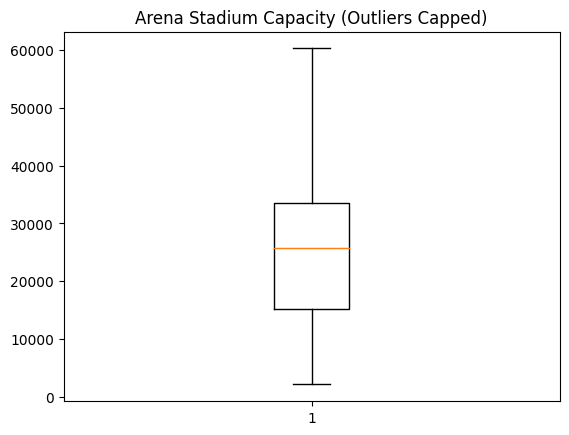

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
# Dealing with outliers
# Create the box plot
fig, ax = plt.subplots()
bp = ax.boxplot(fa_cup_cleaned_features_df['arena_stadium_capacity'])

# Extract the maximum value (whisker cap)
max_value = bp['caps'][1].get_ydata()[0]

# Update the dataframe, setting outliers to the maximum value
fa_cup_cleaned_features_df.loc[fa_cup_cleaned_features_df['arena_stadium_capacity'] > max_value, 'arena_stadium_capacity'] = max_value

# Create a new box plot with the modified data to visualize the result
ax.clear()
ax.boxplot(fa_cup_cleaned_features_df['arena_stadium_capacity'])
plt.title('Arena Stadium Capacity (Outliers Capped)')
plt.show()

# Print the updated dataframe to verify changes
#display(fa_cup_cleaned_features_df)

#fa_cup_cleaned_features_df.describe(include="all")

In [15]:
from sklearn.preprocessing import OneHotEncoder
#Extract categorical columns from the dataframe
#Here we extract the columns with object datatype as they are the categorical columns
categorical_columns = fa_cup_cleaned_features_df.select_dtypes(include=['object']).columns.tolist()

#Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(fa_cup_cleaned_features_df[categorical_columns])

#Create a DataFrame with the one-hot encoded columns
# Use get_feature_names_out() to get the column names for the encoded data
one_hot_fa_cup_cleaned_features_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the one-hot encoded dataframe with the original dataframe
df_encoded = pd.concat([fa_cup_cleaned_features_df, one_hot_fa_cup_cleaned_features_df], axis=1)

# Drop the original categorical columns and moe target variable to the end.
df_encoded = df_encoded.drop(categorical_columns, axis=1)
target_variable_column = df_encoded.pop('target_variable')
df_encoded.insert(len(df_encoded.columns),'target_variable',target_variable_column )

display(df_encoded)


,arena_stadium_capacity,home_team_round_3_position,home_team_massey,home_team_colley,home_team_keener,home_team_trueskill,home_team_borda_count,home_team_local_kemeny_optimisation,home_lineup_strength,home_team_league_form,...,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",target_variable
0,41837,1,1,1,12,1,1,1,0.80,0.72,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,41837,1,1,1,12,1,1,1,0.82,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,41837,1,1,1,12,1,1,1,0.88,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,60260,1,1,1,12,1,1,1,0.82,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,60260,2,3,7,4,6,5,5,0.80,0.67,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,25700,64,58,64,53,63,64,64,0.80,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
301,25700,64,58,64,53,63,64,64,0.80,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
302,9527,64,58,64,53,63,64,64,0.90,0.22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
303,6064,64,58,64,53,63,64,64,0.15,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [16]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Select the columns to normalize
columns_to_normalize = [
    'arena_stadium_capacity',
    'home_team_round_3_position',
    'home_team_massey',
    'home_team_colley',
    'home_team_keener',
    'home_team_trueskill',
    'home_team_borda_count',
    'home_team_local_kemeny_optimisation',
    'away_team_round_3_position',
    'away_team_massey',
    'away_team_colley',
    'away_team_keener',
    'away_team_trueskill',
    'away_team_borda_count',
    'away_team_local_kemeny_optimisation',
    'match_weather_data_hours_feelslike',
    'match_weather_data_hours_humidity',
    'match_weather_data_hours_dew',
    'match_weather_data_hours_precip',
    'match_weather_data_hours_snow',
    'match_weather_data_hours_snowdepth',
    'match_weather_data_hours_windspeed',
    'match_weather_data_hours_pressure',
    'match_weather_data_hours_visibility',
    'match_weather_data_hours_cloudcover'
]

# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the selected columns
normalized_data = scaler.fit_transform(df_encoded[columns_to_normalize])

# Create a new dataframe with the normalized data
normalized_df = pd.DataFrame(normalized_data, columns=columns_to_normalize, index=fa_cup_cleaned_features_df.index)

# Replace the original columns with the normalized values
df_encoded[columns_to_normalize] = normalized_df

# Print the first few rows to verify the changes
display(df_encoded)

# You can also check the summary statistics to confirm the normalization
display(fa_cup_cleaned_features_df[columns_to_normalize].describe())



,arena_stadium_capacity,home_team_round_3_position,home_team_massey,home_team_colley,home_team_keener,home_team_trueskill,home_team_borda_count,home_team_local_kemeny_optimisation,home_lineup_strength,home_team_league_form,...,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",target_variable
0,0.682963,0.000000,0.000000,0.000000,0.174603,0.000000,0.000000,0.000000,0.80,0.72,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.682963,0.000000,0.000000,0.000000,0.174603,0.000000,0.000000,0.000000,0.82,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.682963,0.000000,0.000000,0.000000,0.174603,0.000000,0.000000,0.000000,0.88,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1.000000,0.000000,0.000000,0.000000,0.174603,0.000000,0.000000,0.000000,0.82,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1.000000,0.015873,0.031746,0.095238,0.047619,0.079365,0.063492,0.063492,0.80,0.67,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,0.405266,1.000000,0.904762,1.000000,0.825397,0.984127,1.000000,1.000000,0.80,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
301,0.405266,1.000000,0.904762,1.000000,0.825397,0.984127,1.000000,1.000000,0.80,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
302,0.126949,1.000000,0.904762,1.000000,0.825397,0.984127,1.000000,1.000000,0.90,0.22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
303,0.067355,1.000000,0.904762,1.000000,0.825397,0.984127,1.000000,1.000000,0.15,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


,arena_stadium_capacity,home_team_round_3_position,home_team_massey,home_team_colley,home_team_keener,home_team_trueskill,home_team_borda_count,home_team_local_kemeny_optimisation,away_team_round_3_position,away_team_massey,...,match_weather_data_hours_feelslike,match_weather_data_hours_humidity,match_weather_data_hours_dew,match_weather_data_hours_precip,match_weather_data_hours_snow,match_weather_data_hours_snowdepth,match_weather_data_hours_windspeed,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover
count,305.0,305.0,305.0,305.0,305.0,305.0,305.0,305.0,305.0,305.0,...,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000
mean,26996.901639,32.957377,31.186885,30.881967,31.042623,30.754098,31.386885,31.354098,35.986885,35.390164,...,39.615000,81.705008,38.300984,0.000141,0.000197,0.130639,9.728525,1018.005082,11.423115,65.175902
std,15105.095407,19.815966,19.114987,18.935812,19.51909,18.758556,19.469303,19.48496,18.014244,17.862097,...,14.590771,12.869971,11.424452,0.000881,0.002137,0.686505,4.988857,14.212158,5.890923,28.689887
min,2150.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-8.600000,21.755000,-8.500000,0.000000,0.000000,0.000000,0.400000,982.050000,0.550000,0.000000
25%,15231.0,14.0,14.0,15.0,14.0,15.0,14.0,14.0,21.0,21.0,...,31.900000,75.405000,32.950000,0.000000,0.000000,0.000000,6.000000,1011.200000,7.100000,46.200000
50%,25700.0,33.0,30.0,29.0,29.0,30.0,29.0,29.0,37.0,37.0,...,37.275000,84.647500,37.300000,0.000000,0.000000,0.000000,9.100000,1020.350000,9.900000,72.200000
75%,33597.0,51.0,49.0,48.0,49.0,47.0,50.0,50.0,52.0,51.0,...,42.850000,90.200000,42.700000,0.000000,0.000000,0.000000,12.100000,1028.600000,15.250000,89.600000
max,60260.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,...,93.250000,99.955000,75.600000,0.011000,0.030000,9.895000,29.550000,1041.550000,30.850000,100.000000


In [25]:
features = list(df_encoded)
print(features)

correlation_matrix = df_encoded.corr()
target_correlations = correlation_matrix['target_variable'].sort_values(ascending=False)
print(target_correlations)

# plot correlation matrix
f, ax = pyplot.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)


['arena_stadium_capacity', 'home_team_round_3_position', 'home_team_massey', 'home_team_colley', 'home_team_keener', 'home_team_trueskill', 'home_team_borda_count', 'home_team_local_kemeny_optimisation', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_team_round_3_position', 'away_team_massey', 'away_team_colley', 'away_team_keener', 'away_team_trueskill', 'away_team_borda_count', 'away_team_local_kemeny_optimisation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', 'match_weather_data_hours_pressure', 'match_weather_data_hours_visibility', 'match_weather_dat

In [38]:
def run_logistic_regression(df, target_column, weights=None, n_splits=5, random_state=42):

    # Create the StratifiedKFold object
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Initialize lists to store results
    accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []

    # Prepare the feature set
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        # Split the data
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Train the model
        model = LogisticRegression(class_weight=weights, max_iter=1000)
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(accuracies) / len(accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    return all_y_true, all_y_pred, accuracies, model_name



Running model for round_3_position ranking system
Standard LogisticRegression round_3_position


,arena_stadium_capacity,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_lineup_strength,away_team_league_form,away_team_league_form_home_and_away,away_team_league_promotion_relegation,rivalry_flag,...,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",target_variable,home_team_round_3_position,away_team_round_3_position
0,0.682963,0.80,0.72,0.50,1,0.78,0.06,0.28,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.523810
1,0.682963,0.82,0.00,0.56,1,0.81,0.50,0.67,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.380952
2,0.682963,0.88,0.00,0.67,1,0.77,0.56,0.33,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.746032
3,1.000000,0.82,0.00,0.72,1,0.63,0.00,0.39,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.380952
4,1.000000,0.80,0.67,0.50,1,0.78,0.00,0.61,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.015873,0.698413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,0.405266,0.80,0.00,0.39,0,0.78,0.00,0.28,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.000000,0.285714
301,0.405266,0.80,0.00,0.39,0,0.74,0.56,0.50,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.000000,0.523810
302,0.126949,0.90,0.22,0.39,1,0.67,0.67,0.50,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.000000,0.746032
303,0.067355,0.15,0.00,0.39,0,0.74,0.33,0.44,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.000000,0.111111


Fold 1 Accuracy: 0.721
Fold 2 Accuracy: 0.705
Fold 3 Accuracy: 0.721
Fold 4 Accuracy: 0.705
Fold 5 Accuracy: 0.754
Average Accuracy: 0.721


,metric,Standard LogisticRegression round_3_position
0,Cross-validation Accuracy,0.721
1,Overall Accuracy,0.721
2,Confusion Matrix - True Negative (Class 0),215.000
3,Confusion Matrix - False Positive (Class 1),8.000
4,Confusion Matrix - False Negative (Class 0),77.000
5,Confusion Matrix - True Positive (Class 1),5.000
6,Precision (Class 0),0.736
7,Recall (Class 0),0.964
8,F1-score (Class 0),0.835
9,Precision (Class 1),0.385



Running model for massey ranking system
Standard LogisticRegression massey


,arena_stadium_capacity,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_lineup_strength,away_team_league_form,away_team_league_form_home_and_away,away_team_league_promotion_relegation,rivalry_flag,...,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",target_variable,home_team_massey,away_team_massey
0,0.682963,0.80,0.72,0.50,1,0.78,0.06,0.28,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.476190
1,0.682963,0.82,0.00,0.56,1,0.81,0.50,0.67,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.063492
2,0.682963,0.88,0.00,0.67,1,0.77,0.56,0.33,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.714286
3,1.000000,0.82,0.00,0.72,1,0.63,0.00,0.39,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.063492
4,1.000000,0.80,0.67,0.50,1,0.78,0.00,0.61,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.031746,0.523810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,0.405266,0.80,0.00,0.39,0,0.78,0.00,0.28,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.904762,0.571429
301,0.405266,0.80,0.00,0.39,0,0.74,0.56,0.50,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.904762,0.476190
302,0.126949,0.90,0.22,0.39,1,0.67,0.67,0.50,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.904762,0.714286
303,0.067355,0.15,0.00,0.39,0,0.74,0.33,0.44,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.904762,0.317460


Fold 1 Accuracy: 0.754
Fold 2 Accuracy: 0.754
Fold 3 Accuracy: 0.705
Fold 4 Accuracy: 0.721
Fold 5 Accuracy: 0.738
Average Accuracy: 0.734


,metric,Standard LogisticRegression massey
0,Cross-validation Accuracy,0.734
1,Overall Accuracy,0.734
2,Confusion Matrix - True Negative (Class 0),215.000
3,Confusion Matrix - False Positive (Class 1),8.000
4,Confusion Matrix - False Negative (Class 0),73.000
5,Confusion Matrix - True Positive (Class 1),9.000
6,Precision (Class 0),0.747
7,Recall (Class 0),0.964
8,F1-score (Class 0),0.841
9,Precision (Class 1),0.529



Running model for colley ranking system
Standard LogisticRegression colley


,arena_stadium_capacity,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_lineup_strength,away_team_league_form,away_team_league_form_home_and_away,away_team_league_promotion_relegation,rivalry_flag,...,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",target_variable,home_team_colley,away_team_colley
0,0.682963,0.80,0.72,0.50,1,0.78,0.06,0.28,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.476190
1,0.682963,0.82,0.00,0.56,1,0.81,0.50,0.67,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.158730
2,0.682963,0.88,0.00,0.67,1,0.77,0.56,0.33,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.777778
3,1.000000,0.82,0.00,0.72,1,0.63,0.00,0.39,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.158730
4,1.000000,0.80,0.67,0.50,1,0.78,0.00,0.61,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.095238,0.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,0.405266,0.80,0.00,0.39,0,0.78,0.00,0.28,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.000000,0.666667
301,0.405266,0.80,0.00,0.39,0,0.74,0.56,0.50,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.000000,0.476190
302,0.126949,0.90,0.22,0.39,1,0.67,0.67,0.50,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.000000,0.777778
303,0.067355,0.15,0.00,0.39,0,0.74,0.33,0.44,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.000000,0.174603


Fold 1 Accuracy: 0.721
Fold 2 Accuracy: 0.705
Fold 3 Accuracy: 0.705
Fold 4 Accuracy: 0.721
Fold 5 Accuracy: 0.721
Average Accuracy: 0.715


,metric,Standard LogisticRegression colley
0,Cross-validation Accuracy,0.715
1,Overall Accuracy,0.715
2,Confusion Matrix - True Negative (Class 0),212.000
3,Confusion Matrix - False Positive (Class 1),11.000
4,Confusion Matrix - False Negative (Class 0),76.000
5,Confusion Matrix - True Positive (Class 1),6.000
6,Precision (Class 0),0.736
7,Recall (Class 0),0.951
8,F1-score (Class 0),0.830
9,Precision (Class 1),0.353



Running model for keener ranking system
Standard LogisticRegression keener


,arena_stadium_capacity,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_lineup_strength,away_team_league_form,away_team_league_form_home_and_away,away_team_league_promotion_relegation,rivalry_flag,...,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",target_variable,home_team_keener,away_team_keener
0,0.682963,0.80,0.72,0.50,1,0.78,0.06,0.28,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.174603,0.444444
1,0.682963,0.82,0.00,0.56,1,0.81,0.50,0.67,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.174603,0.142857
2,0.682963,0.88,0.00,0.67,1,0.77,0.56,0.33,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.174603,0.809524
3,1.000000,0.82,0.00,0.72,1,0.63,0.00,0.39,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.174603,0.142857
4,1.000000,0.80,0.67,0.50,1,0.78,0.00,0.61,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.047619,0.476190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,0.405266,0.80,0.00,0.39,0,0.78,0.00,0.28,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.825397,0.396825
301,0.405266,0.80,0.00,0.39,0,0.74,0.56,0.50,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.825397,0.444444
302,0.126949,0.90,0.22,0.39,1,0.67,0.67,0.50,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.825397,0.809524
303,0.067355,0.15,0.00,0.39,0,0.74,0.33,0.44,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.825397,0.095238


Fold 1 Accuracy: 0.738
Fold 2 Accuracy: 0.738
Fold 3 Accuracy: 0.721
Fold 4 Accuracy: 0.754


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5 Accuracy: 0.721
Average Accuracy: 0.734


,metric,Standard LogisticRegression keener
0,Cross-validation Accuracy,0.734
1,Overall Accuracy,0.734
2,Confusion Matrix - True Negative (Class 0),216.000
3,Confusion Matrix - False Positive (Class 1),7.000
4,Confusion Matrix - False Negative (Class 0),74.000
5,Confusion Matrix - True Positive (Class 1),8.000
6,Precision (Class 0),0.745
7,Recall (Class 0),0.969
8,F1-score (Class 0),0.842
9,Precision (Class 1),0.533



Running model for trueskill ranking system
Standard LogisticRegression trueskill


,arena_stadium_capacity,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_lineup_strength,away_team_league_form,away_team_league_form_home_and_away,away_team_league_promotion_relegation,rivalry_flag,...,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",target_variable,home_team_trueskill,away_team_trueskill
0,0.682963,0.80,0.72,0.50,1,0.78,0.06,0.28,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.571429
1,0.682963,0.82,0.00,0.56,1,0.81,0.50,0.67,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.111111
2,0.682963,0.88,0.00,0.67,1,0.77,0.56,0.33,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.825397
3,1.000000,0.82,0.00,0.72,1,0.63,0.00,0.39,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.111111
4,1.000000,0.80,0.67,0.50,1,0.78,0.00,0.61,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.079365,0.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,0.405266,0.80,0.00,0.39,0,0.78,0.00,0.28,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.984127,0.666667
301,0.405266,0.80,0.00,0.39,0,0.74,0.56,0.50,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.984127,0.571429
302,0.126949,0.90,0.22,0.39,1,0.67,0.67,0.50,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.984127,0.825397
303,0.067355,0.15,0.00,0.39,0,0.74,0.33,0.44,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.984127,0.174603


Fold 1 Accuracy: 0.738
Fold 2 Accuracy: 0.738


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3 Accuracy: 0.656
Fold 4 Accuracy: 0.721
Fold 5 Accuracy: 0.721
Average Accuracy: 0.715


,metric,Standard LogisticRegression trueskill
0,Cross-validation Accuracy,0.715
1,Overall Accuracy,0.715
2,Confusion Matrix - True Negative (Class 0),212.000
3,Confusion Matrix - False Positive (Class 1),11.000
4,Confusion Matrix - False Negative (Class 0),76.000
5,Confusion Matrix - True Positive (Class 1),6.000
6,Precision (Class 0),0.736
7,Recall (Class 0),0.951
8,F1-score (Class 0),0.830
9,Precision (Class 1),0.353



Running model for borda_count ranking system
Standard LogisticRegression borda_count


,arena_stadium_capacity,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_lineup_strength,away_team_league_form,away_team_league_form_home_and_away,away_team_league_promotion_relegation,rivalry_flag,...,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",target_variable,home_team_borda_count,away_team_borda_count
0,0.682963,0.80,0.72,0.50,1,0.78,0.06,0.28,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.444444
1,0.682963,0.82,0.00,0.56,1,0.81,0.50,0.67,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.158730
2,0.682963,0.88,0.00,0.67,1,0.77,0.56,0.33,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.809524
3,1.000000,0.82,0.00,0.72,1,0.63,0.00,0.39,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.158730
4,1.000000,0.80,0.67,0.50,1,0.78,0.00,0.61,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.063492,0.539683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,0.405266,0.80,0.00,0.39,0,0.78,0.00,0.28,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.000000,0.476190
301,0.405266,0.80,0.00,0.39,0,0.74,0.56,0.50,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.000000,0.444444
302,0.126949,0.90,0.22,0.39,1,0.67,0.67,0.50,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.000000,0.809524
303,0.067355,0.15,0.00,0.39,0,0.74,0.33,0.44,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.000000,0.142857


Fold 1 Accuracy: 0.721
Fold 2 Accuracy: 0.738


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3 Accuracy: 0.705
Fold 4 Accuracy: 0.721
Fold 5 Accuracy: 0.754
Average Accuracy: 0.728


,metric,Standard LogisticRegression borda_count
0,Cross-validation Accuracy,0.728
1,Overall Accuracy,0.728
2,Confusion Matrix - True Negative (Class 0),214.000
3,Confusion Matrix - False Positive (Class 1),9.000
4,Confusion Matrix - False Negative (Class 0),74.000
5,Confusion Matrix - True Positive (Class 1),8.000
6,Precision (Class 0),0.743
7,Recall (Class 0),0.960
8,F1-score (Class 0),0.838
9,Precision (Class 1),0.471



Running model for local_kemeny_optimisation ranking system
Standard LogisticRegression local_kemeny_optimisation


,arena_stadium_capacity,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_lineup_strength,away_team_league_form,away_team_league_form_home_and_away,away_team_league_promotion_relegation,rivalry_flag,...,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",target_variable,home_team_local_kemeny_optimisation,away_team_local_kemeny_optimisation
0,0.682963,0.80,0.72,0.50,1,0.78,0.06,0.28,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.444444
1,0.682963,0.82,0.00,0.56,1,0.81,0.50,0.67,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.158730
2,0.682963,0.88,0.00,0.67,1,0.77,0.56,0.33,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.809524
3,1.000000,0.82,0.00,0.72,1,0.63,0.00,0.39,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.158730
4,1.000000,0.80,0.67,0.50,1,0.78,0.00,0.61,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.063492,0.539683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,0.405266,0.80,0.00,0.39,0,0.78,0.00,0.28,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.000000,0.476190
301,0.405266,0.80,0.00,0.39,0,0.74,0.56,0.50,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.000000,0.444444
302,0.126949,0.90,0.22,0.39,1,0.67,0.67,0.50,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.000000,0.809524
303,0.067355,0.15,0.00,0.39,0,0.74,0.33,0.44,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.000000,0.142857


Fold 1 Accuracy: 0.721
Fold 2 Accuracy: 0.738


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3 Accuracy: 0.705
Fold 4 Accuracy: 0.721
Fold 5 Accuracy: 0.738
Average Accuracy: 0.725


,metric,Standard LogisticRegression local_kemeny_optimisation
0,Cross-validation Accuracy,0.725
1,Overall Accuracy,0.725
2,Confusion Matrix - True Negative (Class 0),214.000
3,Confusion Matrix - False Positive (Class 1),9.000
4,Confusion Matrix - False Negative (Class 0),75.000
5,Confusion Matrix - True Positive (Class 1),7.000
6,Precision (Class 0),0.740
7,Recall (Class 0),0.960
8,F1-score (Class 0),0.836
9,Precision (Class 1),0.438


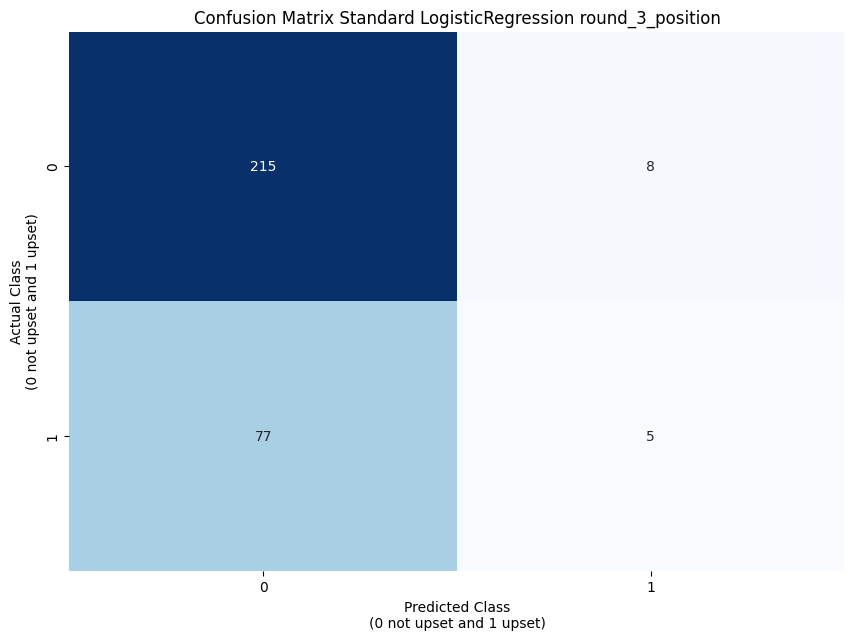

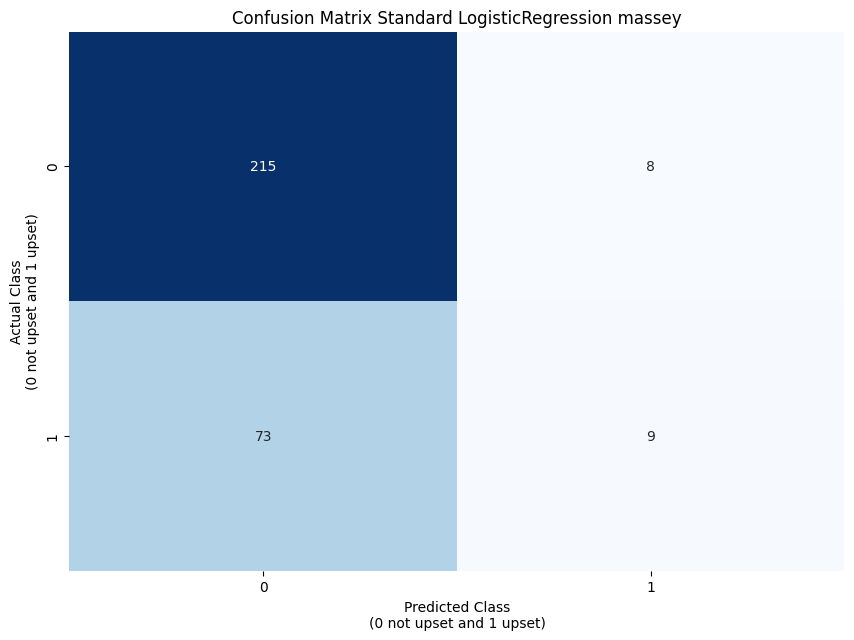

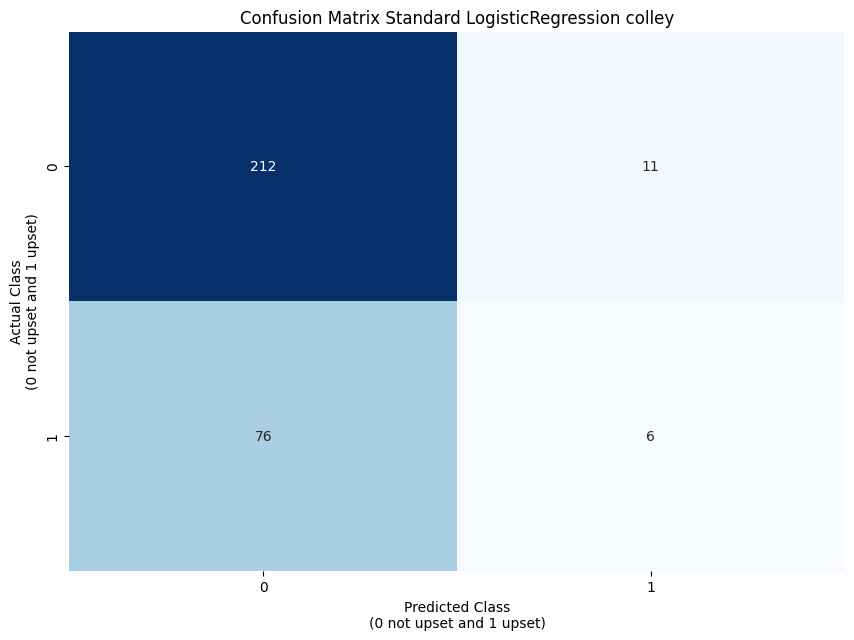

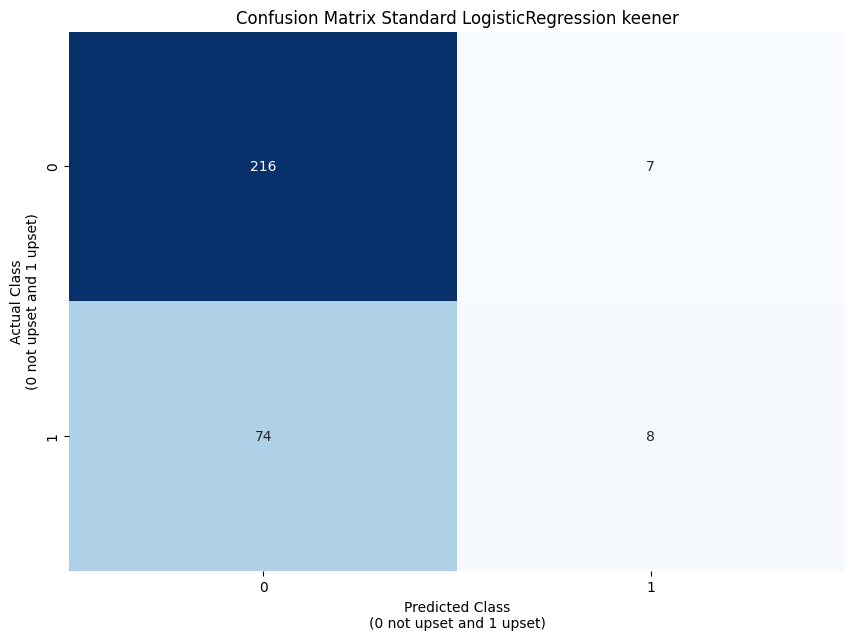

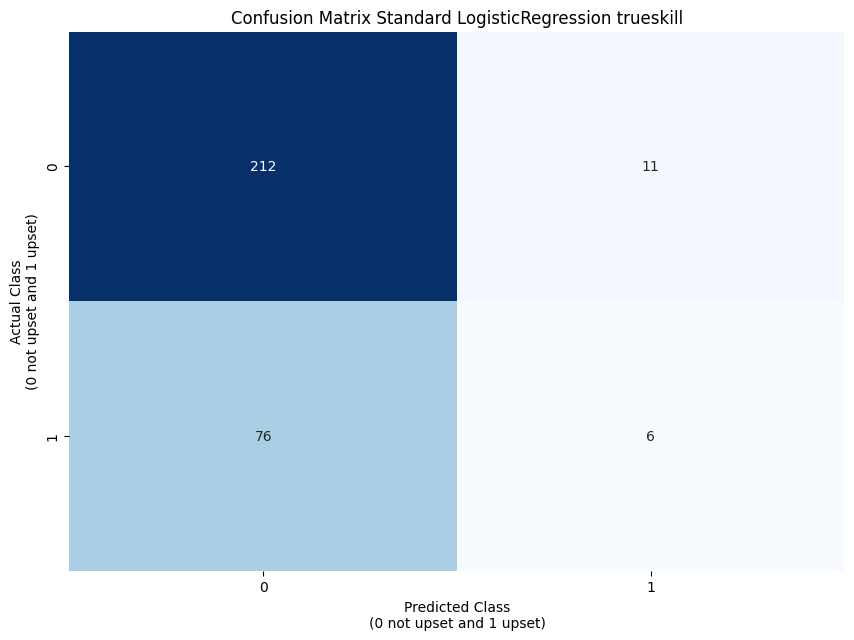

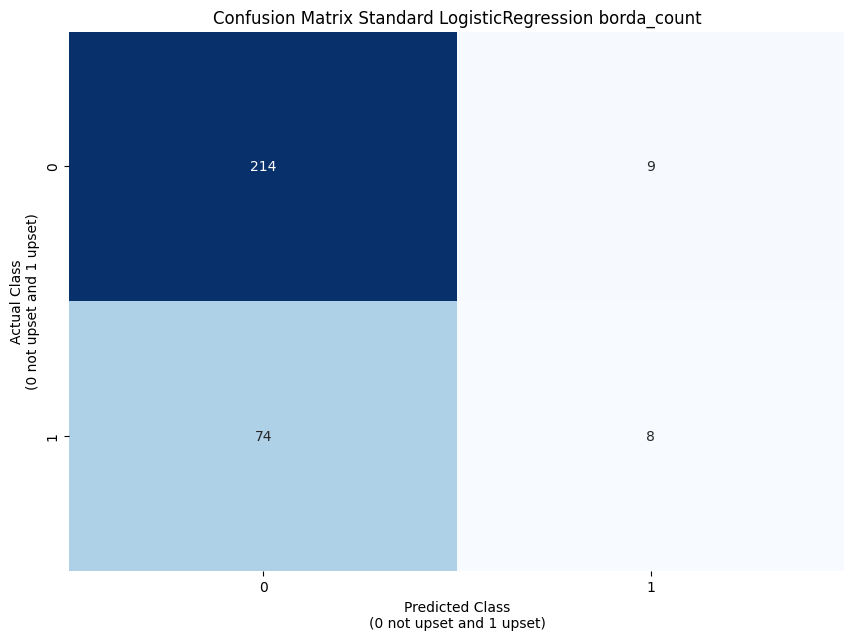

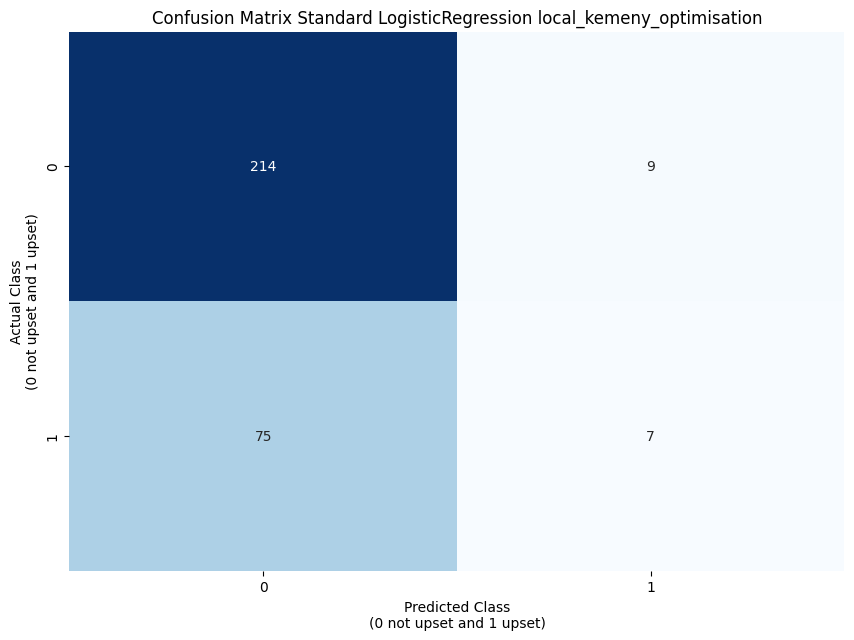

In [47]:
# Import user defined python functions
import model_evaluation_functions
importlib.reload(model_evaluation_functions)
from model_evaluation_functions import create_model_results_df

df_all = df_encoded
#display(df)

#Logistic Regresssion

# Standard, no weights
model_name = "Standard LogisticRegression"
# Define the ranking systems
ranking_systems = ['round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
base_features = [col for col in df_all.columns if not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]

# Loop through each ranking system
for ranking in ranking_systems:
        print(f"\nRunning model for {ranking} ranking system")
        model_name_ranking = model_name + ' ' + ranking
        print(model_name_ranking)
        # Prepare the feature set for the current ranking system
        current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
        df_current = df_all[current_features]
        display(df_current)
        all_y_true, all_y_pred, accuracies, model_name = run_logistic_regression(df_current, 'target_variable')
        results_df_slr = create_model_results_df(all_y_true, all_y_pred, accuracies, model_name_ranking)
        display(results_df_slr)





# Weighted by percentage unbalanced
#model_name = "Weighted LogisticRegression"

# Calculate weights based on % split of class labels (0,1)
#y = df_encoded['target_variable']
#class_counts = y.value_counts()
#total_samples = len(y)
#weights = {class_label: int(round((1 - (count / total_samples)) * 100))
           #for class_label, count in class_counts.items()}
#print(weights)

#all_y_true, all_y_pred, accuracies, model_name = run_logistic_regression(df_encoded, 'target_variable', weights=weights)
#results_df_wlr = create_model_results_df(all_y_true, all_y_pred, accuracies, model_name)
#display(results_df_wlr)

# Combine results dataframes
#combined_results_lr = results_df_slr.merge(results_df_wlr, on='metric')
#display(combined_results_lr)


In [22]:
def run_neural_network(df, target_column, hidden_layer_sizes=(10), features_to_drop=None, n_splits=5, random_state=42):

    # Create the StratifiedKFold object
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Initialize lists to store results
    accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []

    # Prepare the feature set
    X = df.drop(target_column, axis=1)
    if features_to_drop:
        X = X.drop(features_to_drop, axis=1)
    y = df[target_column]

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        # Split the data
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Train the model
        model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                              max_iter=1000,
                              random_state=random_state)

        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(accuracies) / len(accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    return all_y_true, all_y_pred, accuracies, "Neural Network"


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1 Accuracy: 0.738


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2 Accuracy: 0.721


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3 Accuracy: 0.754


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4 Accuracy: 0.721
Fold 5 Accuracy: 0.787
Average Accuracy: 0.744


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


,metric,Standard LogisticRegression,Weighted LogisticRegression,Neural Network
0,Cross-validation Accuracy,0.738,0.564,0.744
1,Overall Accuracy,0.738,0.564,0.744
2,Confusion Matrix - True Negative (Class 0),214.000,130.000,197.000
3,Confusion Matrix - False Positive (Class 1),9.000,93.000,26.000
4,Confusion Matrix - False Negative (Class 0),71.000,40.000,52.000
5,Confusion Matrix - True Positive (Class 1),11.000,42.000,30.000
6,Precision (Class 0),0.751,0.765,0.791
7,Recall (Class 0),0.960,0.583,0.883
8,F1-score (Class 0),0.843,0.662,0.835
9,Precision (Class 1),0.550,0.311,0.536


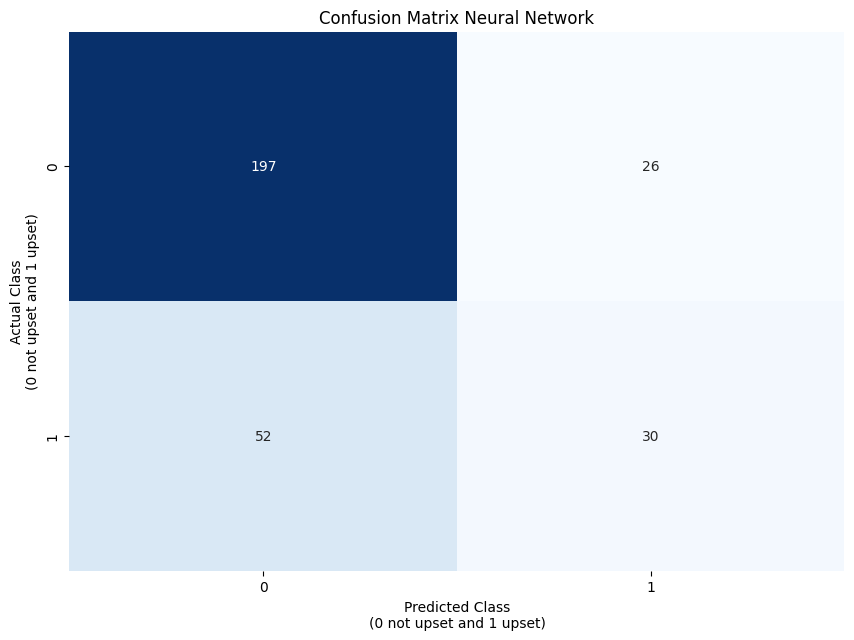

In [23]:
# Import user defined python functions
import model_evaluation_functions
importlib.reload(model_evaluation_functions)
from model_evaluation_functions import create_model_results_df

#Logistic Regresssion

# MCP Neural Network
model_name = "MCP Classifier Neural Network"
all_y_true, all_y_pred, accuracies, model_name = run_neural_network(df_encoded, 'target_variable')
results_df_mcp_nn = create_model_results_df(all_y_true, all_y_pred, accuracies, model_name)

# Combine results dataframes
combined_results = combined_results_lr.merge(results_df_mcp_nn, on='metric')
display(combined_results)